In [2]:
from astropy.table import Table
import numpy as np
import argparse
from jax import jit
import itertools
from scipy import interpolate

from Payne.jax.genmod import GenMod
from runUTPcomp import getdata

import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

import os
import csv
%matplotlib inline

In [3]:
specNN = './models/specNN/modV0_spec_LinNet_R42K_WL510_535_wvt.h5'
photNN = './models/photNN/'
NNtype = 'LinNet'
mistNN = './models/mistNN/mistyNN_2.3_v256_v0.h5'
SBlib  = './models/specNN/c3k_v1.3.sed_r500.h5'

def planck(wav, T):
    h = 6.626e-34
    c = 3.0e+8
    k = 1.38e-23

    wave_i = wav*(1E-10)
    a = 2.0*h*c**2
    b = h*c/(wave_i*k*T)
    intensity = a/ ( (wave_i**5) * (np.exp(b) - 1.0) )
    return intensity

from scipy import constants
speedoflight = constants.c / 1000.0

# useful constants
# speedoflight = 2.997924e+10
speedoflight_kms = 2.997924e+5
speedoflight_nms = 2.997924e+17
lsun = 3.846e33
pc = 3.085677581467192e18  # in cm
jansky_cgs = 1e-23
# value to go from L_sun to erg/s/cm^2 at 10pc
log_rsun_cgs = np.log10(6.955) + 10.0
log_lsun_cgs = np.log10(lsun)
log4pi = np.log10(4 * np.pi)

rng = np.random.default_rng()

In [15]:
# make spectral prediction
data_p = getdata(spec='synth_spec_RV-3.csv', phot='synth_phot_g4.306.csv')
data_s = getdata(spec='synth_spec_RV18.csv', phot='synth_phot_g4.274.csv')

# make sure the wavelengths are the same
np.where(data_p['spec']['obs_wave'] != data_s['spec']['obs_wave'])
waves = data_p['spec']['obs_wave']

In [16]:
logr_p = 1.723
logr_s = 1.504

Teff_p = 9700
Teff_s = 7020

radius_p = 10.0**logr_p
radius_s = 10.0**logr_s

R = (
    (planck(waves,Teff_p) * radius_p**2.0) / 
    (planck(waves,Teff_s) * radius_s**2.0)
     )

speccomp = (data_p['spec']['obs_flux'] + R * data_s['spec']['obs_flux']) / (1.0 + R)
speccomp[:5]

1.0169512204274878
1.0163734016817096
1.015632399082617
1.014977227925742
1.0145990630978554


In [17]:
# sanity checks
print(np.where(R<0))
print(np.where(R<1))

(array([], dtype=int64),)
(array([], dtype=int64),)


In [19]:
# add noise, setting seed for reproducibility
np.random.seed(0)

# mu and sigma come from hectochelle data:
# file: data_ngc6819_2010.0921_ngc6819_sep2010_1.7137.h5
# target id: 2076392838230907392
mu, sigma = 0.055402016862253524, 0.004453214396949145
noise = np.random.normal(mu, sigma, len(speccomp))
speccomp = speccomp + noise
print(speccomp[:5])

       flux       
------------------
1.1434666607600652
1.1307414070889046
1.1351534929704454
1.1457396173636678
1.1420363690801087


(5160.0, 5190.0)

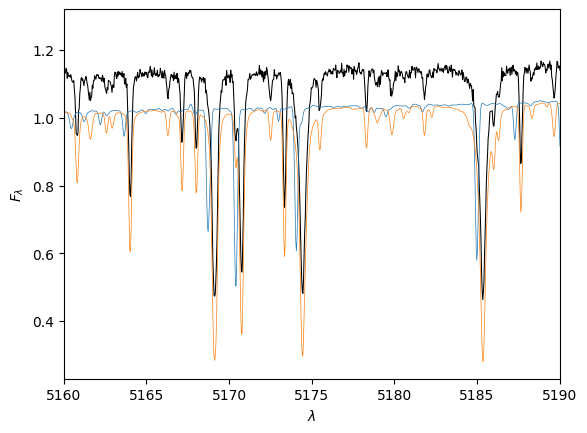

In [23]:
fig, ax = plt.subplots()
ax.plot(waves, speccomp, ls='-',lw=0.75,c='k',zorder=0)
# ax.plot(data_p['spec']['obs_wave'], data_p['spec']['obs_flux']+flux2_interp, ls='-',lw=0.5,c='C3',zorder=0)
ax.plot(waves, data_p['spec']['obs_flux'], ls='-',lw=0.5,c='C0',zorder=1)
ax.plot(waves, data_s['spec']['obs_flux'], ls='-',lw=0.5,c='C1',zorder=1)

ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$F_\lambda$')

ax.set_xlim(5160,5190)

In [24]:
# make phot prediction
for i in data_p['phot'].keys():
    print(i)

phot_p = [data_p['phot'][xx][0] for xx in data_p['phot'].keys()]
phot_s = [data_s['phot'][xx][0] for xx in data_s['phot'].keys()]
print(phot_p, len(phot_p))

photcomp = (
    [-2.5 * np.log10( 10.0**(-0.4 * m_p) + 10.0**(-0.4 * m_s) )
     for m_p,m_s in zip(phot_p,phot_s)
     ] 
)

WAVE_d = {'GaiaDR3_G': 6217.59,
        'GaiaDR3_BP': 5109.71,
        'GaiaDR3_RP': 7769.02,
        '2MASS_J': 12350.0,
        '2MASS_H': 16620.0,
        '2MASS_Ks': 21590.0,
        'PS_g': 4775.6,
        'PS_r': 6129.5,
        'PS_i': 7484.6,
        'PS_z': 8657.8
       }

WAVE = np.array([ii for ii in WAVE_d.values()])
# (len(WAVE_d.values()),
# len(photcomp))

GaiaDR3_G
GaiaDR3_BP
GaiaDR3_RP
2MASS_J
2MASS_H
2MASS_Ks
PS_g
PS_r
PS_i
PS_z
[-0.04551905785571364, 0.03322588853425579, -0.0963883081763246, 0.8569298402963401, 0.7306526350940885, 0.7550602917188902, 0.7415380494522168, 0.8847639389257242, 0.3847025968294675, 0.7051980448654671] 10


In [25]:
# make some errors (taken from the known SB2 Gaia DR3 2076392838230907392)
emags = [0.05000091916311386,
         0.05004763662644478,
         0.050012894094444295,
         0.07733692547677395,
         0.08683893326204858,
         0.10121264701645077,
         0.020829461749839007,
         0.02065512096136038,
         0.020870045165005097,
         0.020915354323712318
        ]

Text(0, 0.5, 'Mag.')

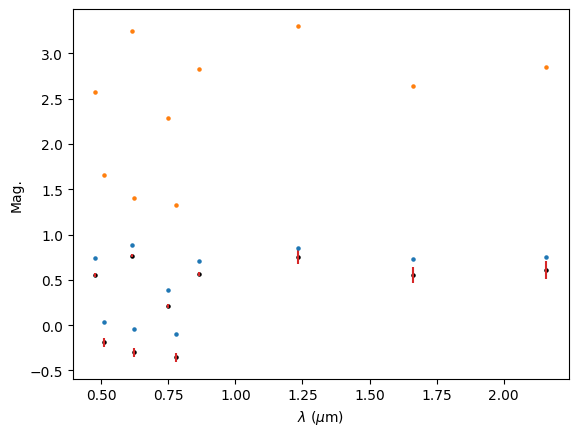

In [28]:
fig, ax = plt.subplots()

for wavelength, mag, err in zip(WAVE, photcomp, emags):
    ax.scatter(wavelength/1E+4, mag, s=5, c='k',zorder=0)
    ax.errorbar(wavelength/1E+4, mag, yerr=err, c='C3',zorder=1)

ax.scatter(WAVE/1E+4, phot_p, s=5, c='C0', zorder=1)
ax.scatter(WAVE/1E+4, phot_s, s=5, c='C1', zorder=1)

ax.set_xlabel(r'$\lambda$ ($\mu$m)')
ax.set_ylabel(r'Mag.')

In [29]:
# output composite spectrum to csv
with open(f'synth_speccomp.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['wave', 'flux', 'eflux'])

    for row in zip(waves, speccomp+noise, noise):
        # print(row)
        csv_out.writerow(row)
print(f'synthetic composite spectrum output to /etc/demo_smes/synth_speccomp.csv')

synthetic composite spectrum output to /etc/demo_smes/synth_speccomp.csv


In [30]:
# output composite photometry to csv
with open(f'synth_photcomp.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['band', 'mag', 'emag'])

    for row in zip(WAVE_d.keys(), photcomp, emags):
        # print(row)
        csv_out.writerow(row)
print(f'synthetic composite photometry output to /etc/demo_smes/synth_photcomp.csv')

synthetic composite photometry output to /etc/demo_smes/synth_photcomp.csv


In [32]:
Table.read('synth_speccomp.csv')[:5]

wave,flux,eflux
float64,float64,float64
5160.033583244636,1.206724380926354,0.06325772016628864
5160.069695358896,1.187925409792502,0.05718400270359742
5160.105807428577,1.1949140399143596,0.05976054694391419
5160.141919453268,1.2111208120826307,0.06538119471896288
5160.178031432559,1.2057550220712354,0.06371865299112676


In [33]:
Table.read('synth_photcomp.csv')[:5]

band,mag,emag
str10,float64,float64
GaiaDR3_G,-0.300139395332607,0.05000091916311386
GaiaDR3_BP,-0.18603254430047844,0.05004763662644478
GaiaDR3_RP,-0.35535683321118866,0.050012894094444295
2MASS_J,0.7485720601952955,0.07733692547677395
2MASS_H,0.5583370421174051,0.08683893326204858


In [36]:
from runUTPbinary_synth import getdata as getdata_synth
test_data = getdata_synth()
test_data

{'spec': {'obs_wave': <Column name='wave' dtype='float64' length=3729>
   5160.033583244636
   5160.069695358896
   5160.105807428577
   5160.141919453268
   5160.178031432559
   5160.214143366036
  5160.2502552532915
   5160.286367093913
  5160.3224788874895
   5160.358590633609
   5160.394702331858
   5160.430813981828
     5160.4669255831
   5160.503037135267
   5160.539148637912
   5160.575260090626
  5160.6113714929925
   5160.647482844599
    5160.68359414503
   5160.719705393872
   5160.755816590713
   5160.791927735134
                 ...
   5289.348165346953
   5289.380496583505
   5289.412825955153
    5289.44515346169
   5289.477479102911
   5289.509802878617
   5289.542124788601
   5289.574444832661
   5289.606763010596
   5289.639079322204
   5289.671393767286
  5289.7037063456355
  5289.7360170570555
   5289.768325901346
   5289.800632878305
   5289.832937987731
    5289.86524122943
   5289.897542603198
   5289.929842108839
   5289.962139746154
  5289.9944355149455,
  'o

(5200.0, 5215.0)

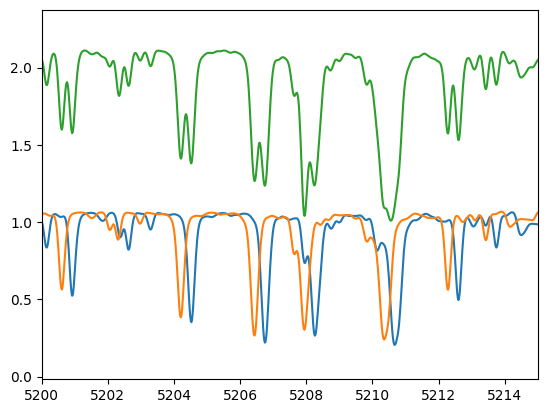

In [17]:
# relearning how interpolation works:
plt.plot(data_p['spec']['obs_wave'], flux2_interp)
plt.plot(data_p['spec']['obs_wave'], data_p['spec']['obs_flux'])
plt.plot(data_p['spec']['obs_wave'], flux2_interp+data_p['spec']['obs_flux'])
plt.xlim(5200,5215)